**Fast and accurate calculations for first-passage times in Wiener diffusion models**  
Daniel Navarro, Ian Fuss (2009)

**PDF**:

$w = z/a$

\begin{align*}
f(t|v,a,w) & =\frac{\pi}{a^2}\exp\left(-vaw-\frac{v^2t}{2}\right) \times\sum_{k=1}^\infty k\exp\left(-\frac{k^2\pi^2t}{2a^2}\right)\sin(k\pi w)
\end{align*}

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pyddm
from autograd import hessian, jacobian
from scipy.optimize import minimize


def pdf(X, y, v, a, z, err=0.001):
    """X>0, X of shape (n_samples,2), a>0, z∈[-1,+1], err<0"""

    x = X if X.ndim == 1 else X[:, 0]

    # to navarro 2009 notation
    a = 2 * a
    v = -y * v
    w = 0.5 * (1 - y * z)

    xt = x / (a**2)  # normalize time

    # kl: number of terms for large t
    kl = np.where(
        np.pi * xt * err < 1,
        np.sqrt(-2 * np.log(np.pi * xt * err) / (np.pi**2 * xt)),
        1 / (np.pi * np.sqrt(xt)),
    )
    kl = np.maximum(kl, 1 / (np.pi * np.sqrt(xt)))

    # ks: number of terms for small t
    ks = np.where(
        2 * np.sqrt(2 * np.pi * xt) * err < 1,
        2 + np.sqrt(-2 * xt * np.log(2 * np.sqrt(2 * np.pi * xt) * err)),
        2,
    )
    ks = np.maximum(ks, np.sqrt(xt) + 1)

    # f(xt|0,1,w)
    mask_small_t = ks < kl

    # small t approximation
    K_small = np.ceil(ks).astype(int)
    Ks_small = np.arange(-((K_small.max() - 1) // 2), ((K_small.max() - 1) // 2) + 1)
    exponent_small = -((w + 2 * Ks_small[:, None]) ** 2) / (2 * xt)
    p_small_t = np.sum((w + 2 * Ks_small[:, None]) * np.exp(exponent_small), axis=0) / np.sqrt(
        2 * np.pi * xt**3
    )

    # large t approximation
    K_large = np.ceil(kl).astype(int)
    Ks_large = np.arange(1, K_large.max() + 1)
    exponent_large = -(Ks_large[:, None] ** 2) * (np.pi**2) * xt / 2
    p_large_t = np.pi * np.sum(
        Ks_large[:, None] * np.exp(exponent_large) * np.sin(Ks_large[:, None] * np.pi * w), axis=0
    )

    # combine small t and large t approximations
    p = np.where(mask_small_t, p_small_t, p_large_t)

    # f(t|v,a,w)
    p *= np.exp(-v * a * w - (v**2) * x / 2) / (a**2)

    return p

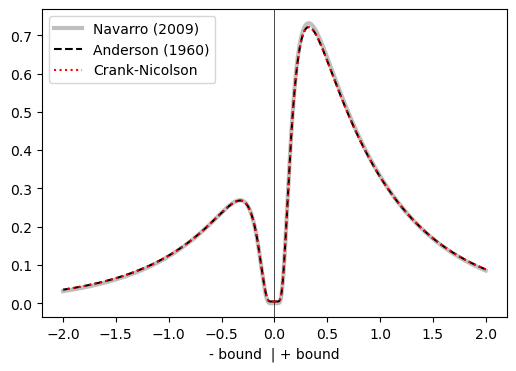

In [2]:
params = {"v": 0.5, "a": 1, "z": 0}

# pyddm
ddm = pyddm.gddm(drift=params["v"], bound=params["a"], starting_position=params["z"])

# anderson: ddm -> pdf
and_sol = ddm.solve_analytical()

# crank-nicolson: ddm -> pdf
cn_sol = ddm.solve_numerical_cn()

# navarro: ddm -> pdf
xmin, xmax, num = 0.001, 2, 500
X = np.r_[np.linspace(xmax, xmin, num), np.linspace(xmin, xmax, num)]
y = np.r_[-np.ones(num), np.ones(num)]
pdfs = pdf(X, y, **params)

# plot densities
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("- bound  | + bound")
ax.axvline(x=0, c="k", lw=0.5)

ax.plot(X * y, pdfs, lw=3, c="k", alpha=0.25, label="Navarro (2009)")
ax.plot(-and_sol.t_domain, and_sol.pdf(choice="error"), ls="--", c="k", label="Anderson (1960)")
ax.plot(-cn_sol.t_domain, cn_sol.pdf(choice="error"), ls=":", c="r", label="Crank-Nicolson")
ax.plot(and_sol.t_domain, and_sol.pdf(choice="correct"), ls="--", c="k")
ax.plot(and_sol.t_domain, cn_sol.pdf(choice="correct"), ls=":", c="r")
ax.legend()

**discretization and sampling**

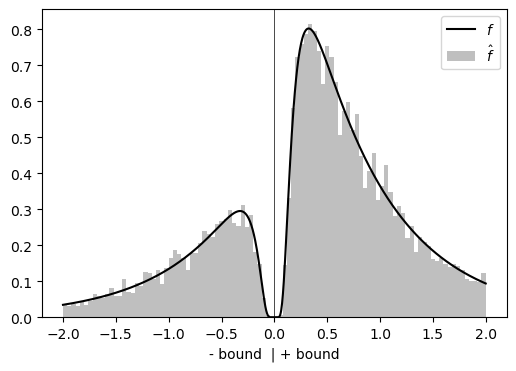

In [3]:
def sample_from_pdf(X, y, params, n_samples=10, seed=0):
    rng = np.random.default_rng(seed=seed)
    pdfs = pdf(X, y, **params)
    probs_ = pdfs / np.sum(pdfs)
    samples = rng.choice(X * y, size=n_samples, p=probs_)
    return np.abs(samples), np.sign(samples)


n_samples = 10000
X_samp, y_samp = sample_from_pdf(X, y, params, n_samples=n_samples)

# plot densities
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("- bound  | + bound")
ax.axvline(x=0, c="k", lw=0.5)

ax.plot(X * y, pdfs / (pdfs.sum() * (xmax - xmin) / num), c="k", label=r"$f$")
ax.hist(X_samp * y_samp, bins=100, density=True, color="k", alpha=0.25, label=r"$\hat f$")
ax.legend()

**maximum likelihood estimation**

In [4]:
def loglikelihood(params, X, y, epsilon=1e-10):
    return np.log(pdf(X, y, *params) + epsilon)


def lossloglikelihood(params, X, y):
    loglikelihood_ = loglikelihood(params, X, y)
    return -np.sum(loglikelihood_)


# define autograd derivatives
ll_jacobian = jacobian(loglikelihood)
lll_jacobian = jacobian(lossloglikelihood)
lll_hessian = hessian(lossloglikelihood)

fit = minimize(
    fun=lossloglikelihood,
    x0=np.array([0.1, 1.0, 0.1]),
    args=(X_samp, y_samp),
    method="Newton-CG",
    jac=lll_jacobian,
    hess=lll_hessian,
)
print(
    "   true\testimate",
    f"v: {params['v']}\t{fit.x[0]:.2f}",
    f"a: {params['a']}\t{fit.x[1]:.2f}",
    f"z: {params['z']}\t{fit.x[2]:.2f}",
    sep="\n",
)

   true	estimate
v: 0.5	0.63
a: 1	0.93
z: 0	-0.05


**standard error estimation**

In [5]:
def newey_west(x, n_lags=None):
    n = len(x)
    if n_lags is None:
        n_lags = int(np.floor(4 * (n / 100.0) ** (2.0 / 9.0)))
    x = x[:, np.newaxis] if x.ndim == 1 else x
    weights = 1 - np.arange(n_lags + 1) / (n_lags + 1)  # bartlett
    S = x.T @ x
    for lag in range(1, n_lags + 1):
        s = x[lag:].T @ x[:-lag]
        S += weights[lag] * (s + s.T)  # symmetric over +/- lags
    return S


# sample hessian estimator
hessian_ = (1 / n_samples) * lll_hessian(fit.x, X, y)
hessian_cov_ = np.linalg.inv(hessian_)
print("sample hessian estimator:\t", np.sqrt((1 / n_samples) * np.diag(hessian_cov_)))

# outer product estimator
jacobian_ = ll_jacobian(fit.x, X, y)
fisher_ = (1 / n_samples) * (jacobian_.T @ jacobian_)  # outer products
fisher_cov_ = np.linalg.inv(fisher_)
print("outer product estimator:\t", np.sqrt((1 / n_samples) * np.diag(fisher_cov_)))

# misspecification robust estimator
robust_var_ = hessian_cov_ @ fisher_ @ hessian_cov_
print("misspecification robust estimator:\t", np.sqrt((1 / n_samples) * np.diag(robust_var_)))

# hac robust (newey-west) estimator
nw_ = (1 / n_samples) * newey_west(jacobian_)
nw_cov_ = hessian_cov_ @ nw_ @ hessian_cov_
print("hac robust (newey-west) estimator:\t", np.sqrt((1 / n_samples) * np.diag(nw_cov_)))

sample hessian estimator:	 [0.03860258 0.01099613 0.0244845 ]
outer product estimator:	 [0.02899758 0.00616668 0.00742807]
misspecification robust estimator:	 [0.07974288 0.02078145 0.08134661]
hac robust (newey-west) estimator:	 [0.19410248 0.05033152 0.19349804]
